# Geneformer - Factor Analysis

In [1]:
from google.colab import drive
from datasets import load_dataset, load_from_disk
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import pandas as pd
import os
import random
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/GitHub/Biological-Foundation-Model/Notebooks')
!pip install -r ../requirements.txt

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 99.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 3.9 MB

In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks/huggingface_models/Geneformer"
!pip install .
from geneformer import TOKEN_DICTIONARY_FILE
from geneformer import perturber_utils as pu
from geneformer import TranscriptomeTokenizer
os.chdir('/content/drive/MyDrive/GitHub/Biological-Foundation-Model/Notebooks')

In [ ]:
# load the training data and the tokenizer from Geneformer
dataset = load_from_disk("/content/drive/My Drive/Colab Notebooks/datasets/geneformer/cell_type_train_data.dataset") # 249556 data points
with open("/content/drive/My Drive/Colab Notebooks/huggingface_models/Geneformer/geneformer/gene_dictionaries_30m/token_dictionary_gc30M.pkl", "rb") as f:
    token_dict = pickle.load(f)

# load model
model = pu.load_model("Pretrained", num_classes = 0, model_directory = "/content/drive/My Drive/Colab Notebooks/huggingface_models/Geneformer/gf-12L-30M-i2048", mode="eval")

In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/Structural_Probe_Gene/data/30M_6L_features/H_list_l6_STRING_10000.pkl", "rb") as f:
    H_list = pickle.load(f)

random.seed(0)
cell_indices = random.sample(list(range(len(dataset))), 10000)
input_ids_list = [dataset[idx]["input_ids"] for idx in cell_indices]

vocab_size = len(token_dict)
feature_dim = 256

count_vector = np.zeros(vocab_size)
sum_matrix = np.zeros((vocab_size, feature_dim))

for H, input_ids in zip(H_list, input_ids_list):
    for j in range(len(input_ids)):
        token_id = input_ids[j]
        sum_matrix[token_id] += H[j]
        count_vector[token_id] += 1

# Compute averages (avoid divide by zero)
avg_matrix = np.zeros_like(sum_matrix)
nonzero_indices = count_vector > 0
avg_matrix[nonzero_indices] = sum_matrix[nonzero_indices] / count_vector[nonzero_indices, np.newaxis]

## Factor Analysis
$\mathbf{X}\in\mathbb{R}^{n\times d}$, we fit the following model ([reference](https://scikit-learn.org/stable/modules/decomposition.html#fa)):
$$
\mathbf{X} = \mathbf{W}\mathbf{H} + \mathbf{M} + \mathbf{E},
$$
where $\mathbf{W}\in \mathbb{R}^{n\times k}$ and $\mathbf{H}\in \mathbb{R}^{k\times d}$.

We then inspect the columns of $\mathbf{W}$. We hope they are sparse because we hope each row of $\mathbf{H}$ can correspond to a concept (a gene class for example) such that only the gene corresponds to the concept can activate it.

However, this is not the case. As seen in the histogram, the factor scores of each column are not sparse.



In [ ]:
n_factors = 10
fa = FactorAnalysis(n_components=n_factors, random_state=0)
X_fa = fa.fit_transform(avg_matrix)

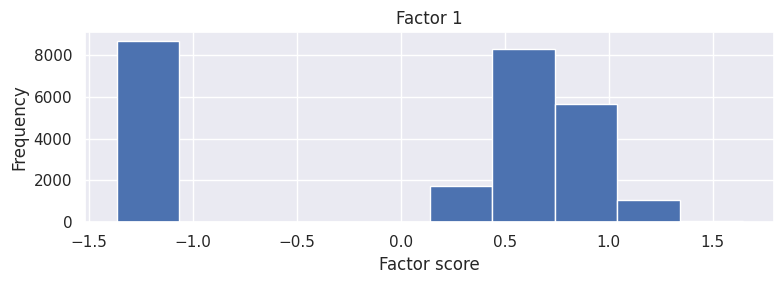

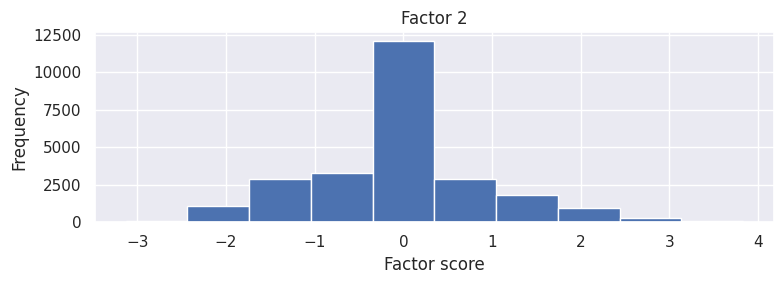

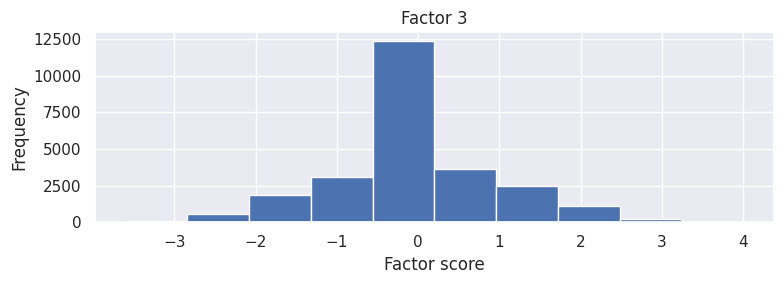

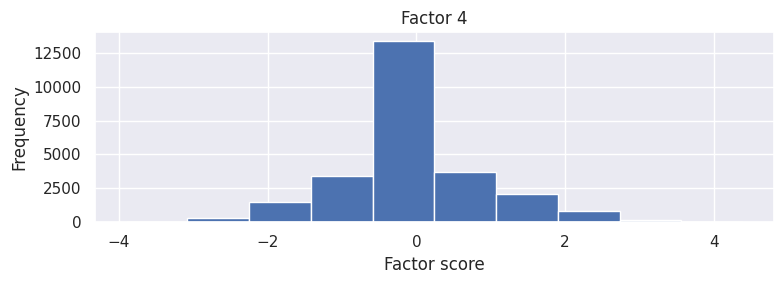

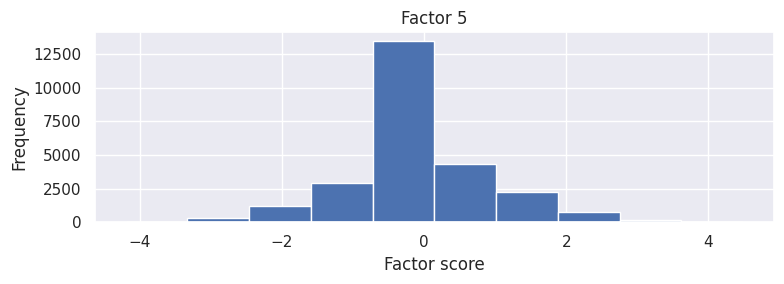

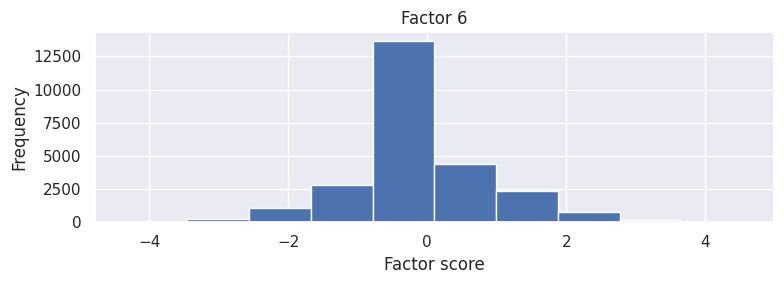

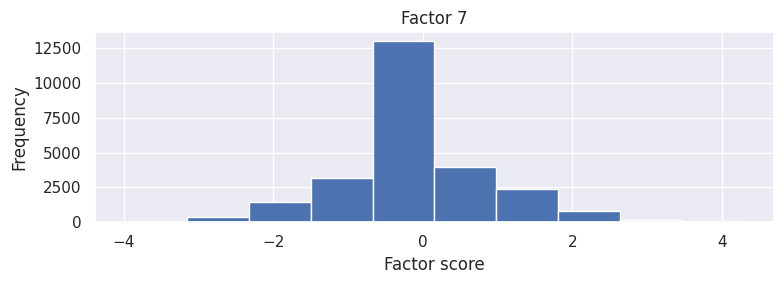

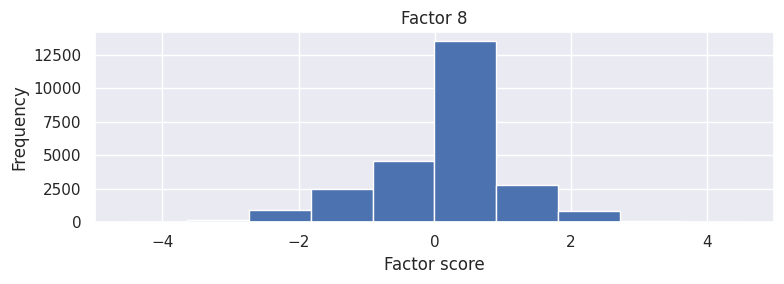

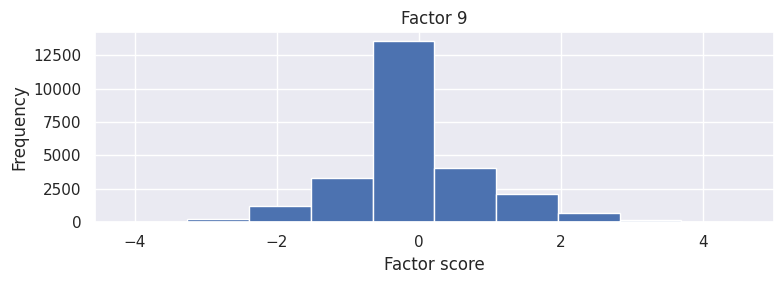

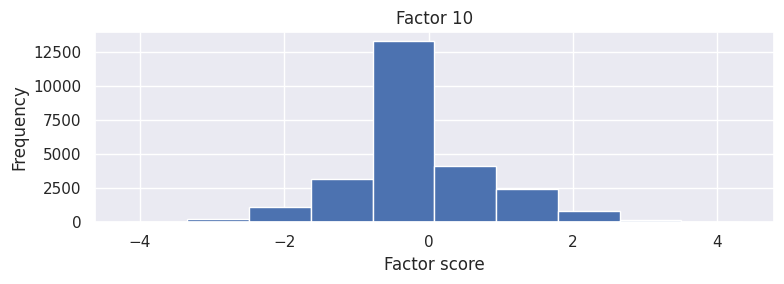

In [ ]:
# Assuming X_fa is the (n_tokens × n_factors) matrix from factor analysis
n_factors = X_fa.shape[1]
n_tokens = X_fa.shape[0]

# Plot each factor's values across tokens
for i in range(n_factors):
    plt.figure(figsize=(8, 3))
    plt.hist(X_fa[:, i])
    plt.xlabel("Factor score")
    plt.ylabel("Frequency")
    plt.title(f"Factor {i + 1}")
    plt.tight_layout()
    plt.show()

Factor 1 looks interesting as many genes have negative score on it.

In [ ]:
gene_indices = np.where(X_fa[:, 0] <= -1)[0]

inverse_token_dict = {v: k for k, v in token_dict.items()}
gene_list_negative_factor_1_score = [inverse_token_dict[idx] for idx in gene_indices if idx in inverse_token_dict]

## Dictionary Learning
TBD